# Named Entity Recognition: RNN vs Pre-Trained Transformer

## Setup

In [1]:
# Data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# GloVe
import gensim.downloader

# DL
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_sequence, unpack_sequence

# Hugging Face
from datasets import load_dataset

c:\Users\markk\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1 RNN

### 1.1 Data Exploration & Analysis

In [2]:
glove_embeddings = gensim.downloader.load("glove-wiki-gigaword-300")

In [3]:
len(glove_embeddings), len(glove_embeddings[0])

(400000, 300)

In [4]:
conll2003_dataset = load_dataset("conll2003")

Found cached dataset conll2003 (C:/Users/markk/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)
100%|██████████| 3/3 [00:00<00:00, 36.78it/s]


In [5]:
[dataset.num_rows for dataset in conll2003_dataset.values()]

[14041, 3250, 3453]

In [6]:
conll2003_dataset['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}

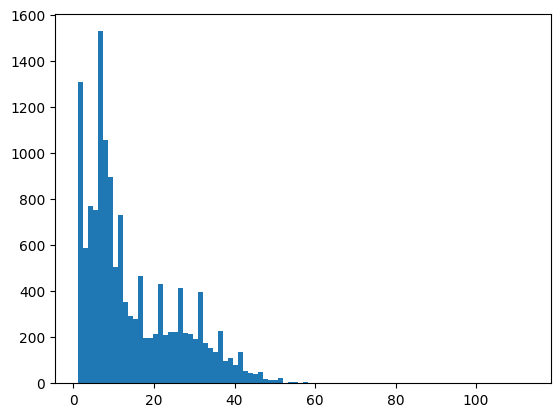

In [7]:
sentences = conll2003_dataset['train'][:]['tokens']
plt.hist([len(s) for s in sentences], bins=90)
plt.show()

In [8]:
tag2id = {tag: i for i, tag in enumerate(conll2003_dataset['train'].features['ner_tags'].feature.names)}
id2tag = {i: tag for i, tag in enumerate(conll2003_dataset['train'].features['ner_tags'].feature.names)}

tag2id, id2tag

({'O': 0,
  'B-PER': 1,
  'I-PER': 2,
  'B-ORG': 3,
  'I-ORG': 4,
  'B-LOC': 5,
  'I-LOC': 6,
  'B-MISC': 7,
  'I-MISC': 8},
 {0: 'O',
  1: 'B-PER',
  2: 'I-PER',
  3: 'B-ORG',
  4: 'I-ORG',
  5: 'B-LOC',
  6: 'I-LOC',
  7: 'B-MISC',
  8: 'I-MISC'})

In [9]:
all_tokens = []

for sequence in conll2003_dataset['train']:
    all_tokens = list(set(all_tokens + sequence['tokens']))
    
print(len(all_tokens))

all_tokens = []

for sequence in conll2003_dataset['validation']:
    all_tokens = list(set(all_tokens + sequence['tokens']))
    
print(len(all_tokens))

23623
9966


In [10]:
max_len = 500

def get_keys_from_DataSet(DS_NAME, keys = ['tokens','ner_tags']):
     return [conll2003_dataset[DS_NAME][:max_len].get(key) for key in keys]
 

# Split data
train_data, train_label = get_keys_from_DataSet('train')
val_data, val_label= get_keys_from_DataSet('validation')
test_data, test_label  = get_keys_from_DataSet('test')

### 1.2 Dataset & Dataloader

In [11]:
UNKNOWN = '<unk>'

vocab = []
for line in train_data:
  vocab += line
vocab+= [UNKNOWN]

# Create dictionaries to convert between tokens and indices
token_to_index = {tok: i for i, tok in enumerate(set(vocab))}
index_to_token = {i: tok for i, tok in enumerate(set(vocab))}

def word_to_index(word):
    if word in token_to_index:
        return token_to_index[word]
    return token_to_index[UNKNOWN]

In [12]:
class LanguageModelDataset(Dataset):
    def __init__(self, data, labels):      
        data_as_index = [list(map(word_to_index, sentence)) for sentence in data]  
        self.X = data_as_index
        self.y = labels

    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def __len__(self):
        return len(self.y)

In [13]:
train_dataset = LanguageModelDataset(train_data, train_label)
val_dataset = LanguageModelDataset(val_data, val_label)
test_dataset = LanguageModelDataset(test_data, test_label)

In [14]:
def my_collate_fn(batch):
    padded_batch = pack_sequence([torch.tensor(sample[0], dtype=torch.long) for sample in batch], enforce_sorted=False)
    labels = pack_sequence([torch.tensor(sample[1], dtype=torch.long) for sample in batch], enforce_sorted=False)
    return padded_batch, labels

In [15]:
batch_size = 1

# Create a DataLoader object
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, collate_fn=my_collate_fn)

In [16]:
print(train_data[0], train_label[0])
print()

# print batch
for sentence, labels in train_dataloader:
    [print(a) for a in zip([[index_to_token[word] for word in token_ind.tolist()] for token_ind in unpack_sequence(sentence)],
          [label.tolist() for label in unpack_sequence(labels)])]
    break

print('\n')

#print whole data
for sentence, labels in train_dataloader:
    [print(a) for a in zip([[index_to_token[word] for word in token_ind.tolist()] for token_ind in unpack_sequence(sentence)],
          [label.tolist() for label in unpack_sequence(labels)])]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'] [3, 0, 7, 0, 0, 0, 7, 0, 0]

(['AL-ANWAR'], [3])


(['I', 'have', 'stayed', 'out', 'of', 'the', 'way', 'and', 'let', 'them', 'get', 'on', 'with', 'the', 'job', '.'], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
(['Bonn', 'has', 'led', 'efforts', 'to', 'ensure', 'consumer', 'protection', 'tops', 'the', 'list', 'of', 'priorities', 'in', 'dealing', 'with', 'the', 'mad', 'cow', 'crisis', ',', 'which', 'erupted', 'in', 'March', 'when', 'Britain', 'acknowledged', 'humans', 'could', 'contract', 'a', 'similar', 'illness', 'by', 'eating', 'contaminated', 'beef', '.'], [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
(['(', 'Switzerland', ')', '6-3', '3-6', '7-6', '(', '8-6', ')'], [0, 5, 0, 0, 0, 0, 0, 0, 0])
(['A', 'U.S.-led', 'air', 'force', 'in', 'southern', 'Turkey', 'protects', 'Iraqi', 'Kurds', 'from', 'possible', 'attacks', 'by', 'Baghdad

(['He', 'said', 'that', 'there', 'are', 'an', 'estimated', '800', 'Polish', 'nurses', 'working', 'in', 'Libya', '.'], [0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 5, 0])
(['Volkswagen', 'AG', 'won', '77,719', 'registrations', ',', 'slightly', 'more', 'than', 'a', 'quarter', 'of', 'the', 'total', '.'], [3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
(['He', '(', 'Mind', 'Games', ')', 'was', 'going', 'as', 'well', 'as', 'any', 'of', 'them', 'one', 'and', 'a', 'half', 'furlongs', '(', '300', 'metres', ')', 'out', 'but', 'he', 'just', 'did', "n't", 'quicken', '.', '"'], [0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
(['MOODY', 'AA1', 'LISTING', 'LUX', 'PAY', 'FREQ', '='], [0, 0, 0, 0, 0, 0, 0])
(['Kindercare', 'says', 'debt', 'buy', 'to', 'hit', 'Q1', 'results', '.'], [0, 0, 0, 0, 0, 0, 0, 0, 0])
(['Israel', 'on', 'Wednesday', 'sent', 'Syria', 'a', 'message', ',', 'via', 'Washington', ',', 'saying', 'it', 'was', 'committed', 'to', 'peace', 'and', 'wan

In [17]:
def use_glove(word):
     if word in glove_embeddings:
          return glove_embeddings[word]
     else:
          return np.zeros((300))


### 1.3 Model 

#### 1.3.1 Definition

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_layers = 1,embedding_dim = 300):
        super().__init__()
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, vocab_size)

    def forward(self, input_sequence):
        
        # Unpack the input sequence into individual tokens
        unpacked_sequence = unpack_sequence(input_sequence)

        # Execute a forward pass of the LSTMModel
        batch_size = len(unpacked_sequence)
        
        # Convert each token into an embedding vector
        embedded_sequence = [torch.tensor([use_glove(index_to_token[word]) for word in token.tolist()], dtype=torch.float) for token in unpacked_sequence]
        
        # Pack the embedded sequence for variable length support
        packed_sequence = pack_sequence(embedded_sequence, enforce_sorted=False)
        
        # Pass the packed sequence through the LSTM layer
        lstm_output, (hidden_state, cell_state) = self.lstm(packed_sequence)
 
        output = []
        # unpack the LSTM output and pass it through the linear layer
        
        for out in unpack_sequence(lstm_output):
            output.append(self.fc(out))
            
        # Return the final output
        return torch.stack(output)


In [20]:
def labels_into_onehot(labels):
    res = []
    for label in labels:
        onehot = np.zeros(len(tag2id),dtype=np.float64)
        onehot[label] = 1.0
        res.append(torch.tensor(onehot,dtype=torch.float))
    return torch.stack(res)

def batch_into_onehot(batch):
    return torch.stack([labels_into_onehot(labels) for labels in batch])

#### 1.3.2 Experiments

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_losses = []
val_losses = []

def train(model, lr=0.001, num_epochs=40):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    loss = None

    # Train the model
    for epoch in range(num_epochs):
      train_loss = 0.0
      val_loss = 0.0

      model.train()
      for inputs, targets in train_dataloader:

          inputs = inputs.to(device)
          targets = targets.to(device)
          
          # Zero the gradients and forward pass
          model.zero_grad()
        
          outputs = model(inputs)

          loss = criterion(outputs, batch_into_onehot(unpack_sequence(targets)))

          # Backward pass and optimization step
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          
      # Validation
      model.eval()
      with torch.no_grad():

        for inputs, targets in val_dataloader:

            inputs = inputs.to(device)
            targets = targets.to(device)

            # Zero the gradients and forward pass
            model.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, batch_into_onehot(unpack_sequence(targets)))

            val_loss += loss.item()
        
        # Calculate average losses
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)

        # Save losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Perplexity: {np.exp(val_loss):.4f}')
        
        # Check if validation loss is increasing, and break the loop if it is
        if  epoch > 1 and val_losses[-1] >= val_losses[-2] and val_losses[-2] >= val_losses[-3]:
            break
            
tag_vocab_size = len(tag2id)
hidden_dim = 400

# Create the model and train it
model = LSTMModel(tag_vocab_size,  hidden_dim)


train(model)

KeyboardInterrupt: 

#### 1.3.3 Evaluation

## 2 Pre-Trained Transformer

### 2.1 Dataset & Dataloader

### 2.2 Fine-Tuning

#### 2.3 Comparison to RNN

#### 2.3.1 Setups

#### 2.3.2 Approaches

#### 2.3.3 Error Analysis

## 3 Conclusions